#### **Imports**

In [27]:
## import essential modules 
import qumcmc 
from qumcmc.energy_models import IsingEnergyFunction
from qumcmc.classical_mcmc_routines import *
from qumcmc.quantum_mcmc_routines import *
from qumcmc.basic_utils import *

#### **Define the Energy Model**

In [62]:
# define the model
np.random.seed(12358)# should always be in the same cell!  
n_spins = 20

## construct problem Hamiltonian ##
shape_of_J=(n_spins,n_spins)

## defining J matrix (mutual 1-1 interaction)
# J =  np.round(np.random.choice([+1, 0, -1], size=(n_spins, n_spins)), decimals=2) 
J =  np.random.uniform(low= -1, high= 1, size= (n_spins, n_spins) )

J = 0.5 * (J + J.transpose() )
J = np.round( J - np.diag(np.diag(J)) , decimals= 3)

# defining h
h = np.round(np.random.randn(n_spins), decimals=2)#np.random.uniform(low= -1, high = 1, size= (n_spins))

# instantiate the model
model = IsingEnergyFunction(J, h, name= 'my_model')


            MODEL : my_model
Non-zero Interactions (J) :  378
Non-zero Bias (h) :  20
---------------------------------------------
Average Interaction Strength <J> :  0.009065
Average Bias Strength <h>:  -0.11750000000000001
alpha :  0.640097946371359
model beta :  1.0
---------------------------------------------


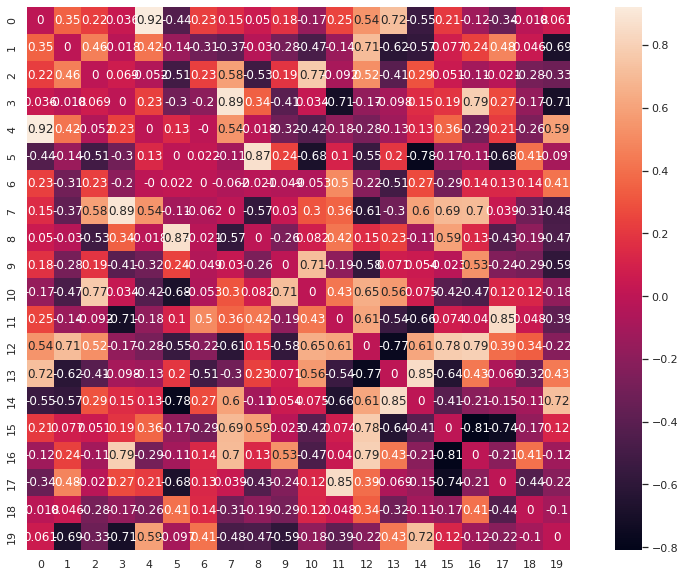

In [63]:
model.model_summary()

#### **Exact Analysis**

In [67]:
## set current beta
beta = 1.2009

## run exact sampling over all possible configurations 
model.run_exact_sampling(beta)

Running Exact Sampling | Model beta :  1.4


running over all possible configurations: 100%|██████████| 1048576/1048576 [01:00<00:00, 17229.78it/s]


saving distribution to model ...


In [68]:
model.exact_sampling_status

True

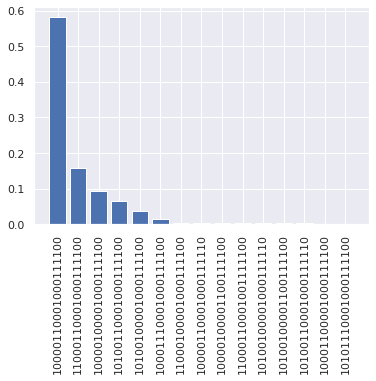

In [69]:
## get the distribution from model
bpd = model.boltzmann_pd

## plot the distribution
plot_bargraph_desc_order(bpd, label= 'Boltzmann Dist.', plot_first_few= 15)

#### **Run Classical MCMC**

In [70]:
steps = 1000
config_counts_c, proposed_states_c, accepted_states_c =classical_mcmc(
    N_hops=steps,
    model=model,
    return_last_n_states=10,
    return_additional_lists=True,
    temp=1/beta,
)

starting with:  11011101100100010011


running MCMC steps ...: 100%|██████████| 1000/1000 [00:00<00:00, 5075.13it/s]


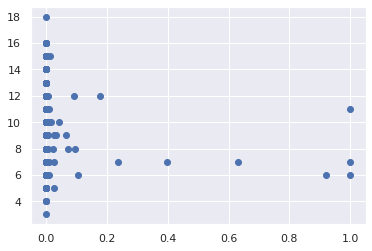

In [75]:
energy_diff = []; hamming_diff= []; transition_probs= []
proposed_states = proposed_states_c
accepted_states = accepted_states_c

for s in range(len(accepted_states)-1):
    hamming_diff.append(hamming_dist(proposed_states[s+1], accepted_states[s]))
    transition_probs.append( min(1, model.get_boltzmann_prob(proposed_states[s+1]) / model.get_boltzmann_prob(accepted_states[s])) )

plt.scatter(transition_probs, hamming_diff)

(array([[  4.,  22., 109., 120., 339., 158., 174.,  43.,  20.,   1.],
        [  0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.],
        [  0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   3.,   0.,   0.,   1.,   0.,   0.,   0.,   0.]]),
 array([2.34557758e-18, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
        4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
        8.00000000e-01, 9.00000000e-01, 1.00000000e+00]),
 array([ 3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. , 16.5, 18. ]),
 <matplotlib.collect

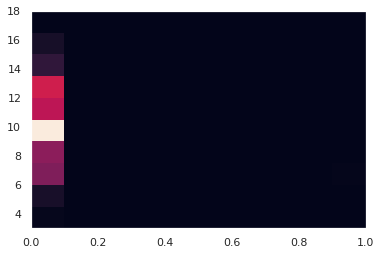

In [76]:
plt.hist2d(transition_probs, hamming_diff)

#### **Run Quantum Enhaned MCMC**

In [71]:
steps = 100
config_counts_q, proposed_states_q, accepted_states_q =quantum_enhanced_mcmc(
    N_hops=steps,
    model=model,
    return_last_n_states=10,
    return_additional_lists=True,
    temp=1/beta,
)

starting with:  11001111111000010011


runnning quantum MCMC steps . ..: 100%|██████████| 100/100 [03:28<00:00,  2.09s/it]


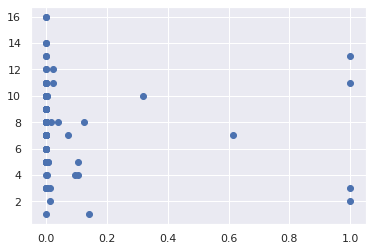

In [93]:
energy_diff = []; hamming_diff= []; transition_probs= []
proposed_states = proposed_states_q
accepted_states = accepted_states_q

for s in range(len(accepted_states)-1):
    hamming_diff.append(hamming_dist(proposed_states[s+1], accepted_states[s]))
    transition_probs.append( min(1, model.get_boltzmann_prob(proposed_states[s+1]) / model.get_boltzmann_prob(accepted_states[s])) )

plt.scatter(transition_probs, hamming_diff)

In [105]:
fills, xticks, yticks = np.histogram2d(transition_probs, hamming_diff, normed= True)

<AxesSubplot:>

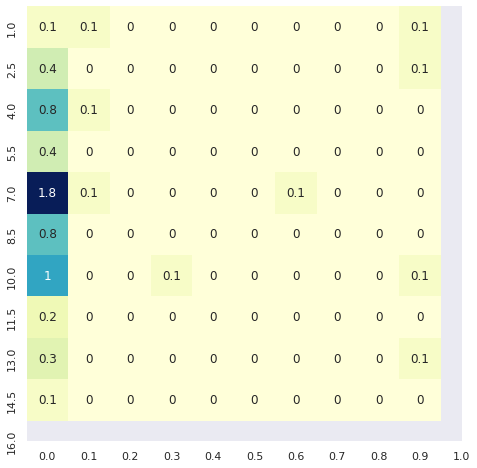

In [108]:
plt.figure(figsize=(8,8))
sns.heatmap(np.round(fills.transpose(), decimals=1), square= True, xticklabels= np.round( xticks.transpose(), decimals= 1) , yticklabels= yticks.transpose(), cmap="YlGnBu", cbar= False, annot= True)

#### **Convergence Analysis**

##### Magnetisation

##### JS Divergence